In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import numpy as np
from Bio import SeqIO
from pyteomics import fasta, parser, mass, achrom, electrochem, auxiliary
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sys.stdout.write("Imported required packages successfully.\n")

Imported required packages successfully.


## Determine _in silico_ (H,L) m/z values

In [2]:
# for each SILAC m/z pair (L,H)
# determine the window bin
# count the mismatched window bins

# read in FASTA
fasta_file = os.path.join(os.getcwd(), 
                          "../../../resources/fasta/human_20350entries_20191016_uniprot-proteome_UP000005640+reviewed_yes.fasta")


silac_df = pd.DataFrame()  # Initialize a dataframe to store results
counter = 0
for protein in tqdm(SeqIO.parse(fasta_file, "fasta")):
    
    #if counter % 10 == 0:
    #    sys.stderr.write("Digestion status: %d\r" % counter)
    
    light_sequence = str(protein.seq).upper()
    
    light_peptides = list(parser.cleave(light_sequence, parser.expasy_rules['trypsin']))
    
    # add K[+8.014199] and R[+10.008269] to the light peptides
    heavy_peptides = [peptide.replace("K", "K[+8.014199]") for peptide in light_peptides]
    heavy_peptides = [peptide.replace("R", "R[+10.008269]") for peptide in heavy_peptides]
    
    # add this protein to the dataframe
    new_df = pd.DataFrame({'light': light_peptides,
                           'heavy': heavy_peptides})
    
    silac_df = silac_df.append(new_df)
        
    counter += 1

silac_df.drop_duplicates(inplace=True)  # ignore nonunique peptides
silac_df = silac_df[silac_df['light'].notna()]  # drop any nan peptides(?)
silac_df = silac_df[silac_df['light'].str.len() > 5]  # drop peptides <5 aa

sys.stdout.write("Finished in silico digestion and generating light/heavy peptides.\n")


def calculate_mz(row):
    mz = mass.calculate_mass(parser.parse(row['light'], show_unmodified_termini=True), ion_type='M', charge=row['z'])
    return mz

def calculate_heavy_mz(row):
    mz_heavy = 0
    if row['light'][-1] == 'R':
        mz_heavy = row['mz_light']+(10.008269/row['z'])
    elif row['light'][-1] == 'K':
        mz_heavy = row['mz_light']+(8.014199/row['z'])
    return mz_heavy


# calculate m/z
silac_df['z'] = silac_df['light'].str.count('R') + silac_df['light'].str.count('K') + silac_df['light'].str.count('H') + 1
silac_df = silac_df[(silac_df['z'] == 2) | (silac_df['z'] == 3)]
silac_df['mz_light'] = silac_df.apply(calculate_mz, axis=1)
silac_df['mz_heavy'] = silac_df.apply(calculate_heavy_mz, axis=1)

sys.stdout.write("Finished calculating m/z of heavy peptides.\n")

#silac_df.to_csv("../data/simulated/silac_insilico_nomissedcleavages_charge2.csv", index=False)
silac_df.head()

20350it [08:31, 39.75it/s]


Finished in silico digestion and generating light/heavy peptides.
Finished calculating m/z of heavy peptides.


,light,heavy,z,mz_light,mz_heavy
0,WVSSSLR,WVSSSLR[+10.008269],2,417.727052,422.731187
2,GGSGEGVSCIIR,GGSGEGVSCIIR[+10.008269],2,567.782230,572.786365
3,IHNVTASDSGK,IHNVTASDSGK[+8.014199],3,376.859643,379.531043
4,YLCYFQDGDFYEK,YLCYFQDGDFYEK[+8.014199],2,845.858332,849.865431
5,GENIPAVEAPVVADGVGLYEVAASVIMR,GENIPAVEAPVVADGVGLYEVAASVIMR[+10.008269],2,1413.738942,1418.743076


## Determine _in silico_ (H,L) pair window mismatches

In [3]:
# read in windowing scheme per DIA_windowing_schemes_for_thermo_instruments.xlsx (400-1000 m/z, 75x8mzol)
windows_df = pd.read_csv("../data/simulated/dia_windowing_scheme_75x8mzol.csv")

# create isolation "bins" for each window
window_bins = sorted(list(windows_df['Start m/z']))
window_bins.append(sorted(windows_df['Stop m/z'])[-2])
window_bins.append(sorted(windows_df['Stop m/z'])[-1])
window_bins = sorted(window_bins)

# assign light, heavy peptides to their appropriate window
silac_df['window_light'] = pd.cut(x=silac_df['mz_light'].astype(float), bins=window_bins)
silac_df['window_heavy'] = pd.cut(x=silac_df['mz_heavy'].astype(float), bins=window_bins)

# calculate the number of split (monoisotopic) precursors
def mismatch_detect(row):
    if row['window_light'] != row['window_heavy']:
        return '1'
    else:
        return '0'
    
silac_df['mismatch'] = silac_df.apply(lambda x: mismatch_detect(x), axis=1)
silac_df.to_csv("../data/simulated/silac_insilico_nomissedcleavages.csv", index=False)

sys.stdout.write("Percent of peptides with L/H precursors falling in wrong windows: %f\n" % 
                 (sum(silac_df['mismatch'].astype(int))/len(silac_df)))
sys.stdout.write("Percent of +2 peptides with L/H precursors falling in wrong windows: %f\n" % 
                 (sum(silac_df[silac_df['z'] == 2]['mismatch'].astype(int))/len(silac_df[silac_df['z'] == 2])))
sys.stdout.write("Percent of +3 peptides with L/H precursors falling in wrong windows: %f\n" % 
                 (sum(silac_df[silac_df['z'] == 3]['mismatch'].astype(int))/len(silac_df[silac_df['z'] == 3])))

Percent of peptides with L/H precursors falling in wrong windows: 0.960665
Percent of +2 peptides with L/H precursors falling in wrong windows: 1.000000
Percent of +3 peptides with L/H precursors falling in wrong windows: 0.865717


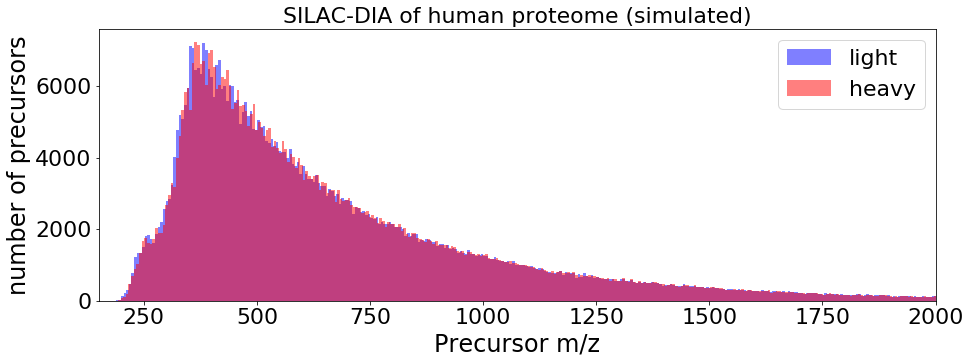

In [4]:
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.subplots(figsize=(15, 5), facecolor='white')
plt.hist(silac_df['mz_light'], bins=5000, alpha=0.5, color='blue', label='light')
plt.hist(silac_df['mz_heavy'], bins=5000, alpha=0.5, color='red', label='heavy')
plt.xlim(150, 2000)
plt.legend(loc='upper right')
plt.title('SILAC-DIA of human proteome (simulated)')
plt.ylabel('number of precursors')
plt.xlabel('Precursor m/z')

#plt.show()
plt.savefig('../results/simulated_precursor_dist_full.svg', 
            transparent=True, bbox_inches='tight', pad_inches=0.5)

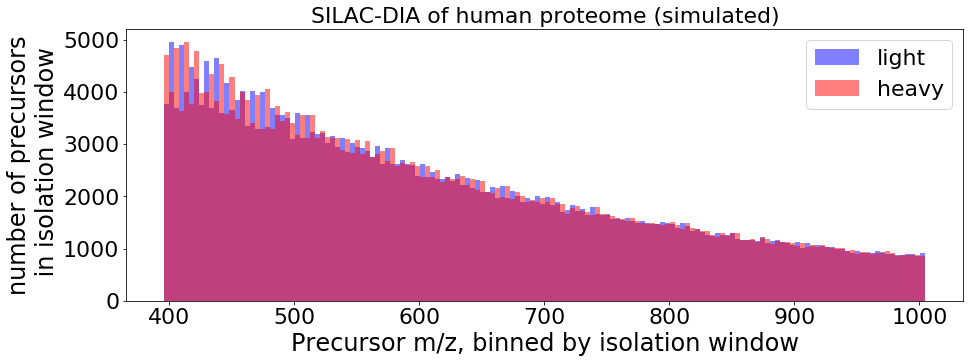

In [5]:
plt.subplots(figsize=(15, 5), facecolor='white')
plt.hist(silac_df['mz_light'], window_bins, alpha=0.5, color='blue', label='light')
plt.hist(silac_df['mz_heavy'], window_bins, alpha=0.5, color='red', label='heavy')
plt.legend(loc='upper right')
plt.title('SILAC-DIA of human proteome (simulated)')
plt.ylabel('number of precursors\n in isolation window')
plt.xlabel('Precursor m/z, binned by isolation window')
#plt.show()
plt.savefig('../results/simulated_precursor_dist.svg', 
            transparent=True, bbox_inches='tight', pad_inches=0.5)

Text(0.5, 0, 'Precursor isotope m/z')

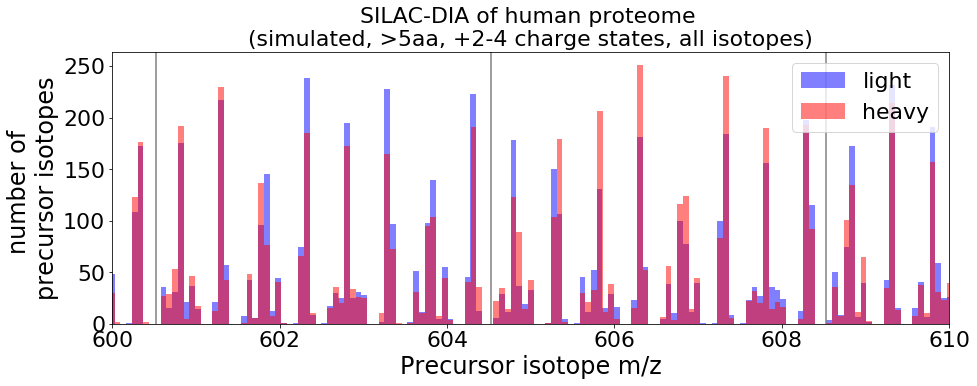

In [6]:
plt.subplots(figsize=(15, 5), facecolor='white')
temp1 = silac_df[silac_df['mz_light'].between(599, 611, inclusive=False)]
temp2 = silac_df[silac_df['mz_heavy'].between(599, 611, inclusive=False)]
plt.hist(temp1['mz_light'], bins=175, alpha=0.5, color='blue', label='light')
plt.hist(temp2['mz_heavy'], bins=175, alpha=0.5, color='red', label='heavy')
plt.axvline(x=600.5228,color='gray')
plt.axvline(x=608.5265,color='gray')
plt.axvline(x=604.52466,color='gray')
plt.xlim(600, 610)
plt.legend(loc='upper right')
plt.title('SILAC-DIA of human proteome \n(simulated, >5aa, +2-4 charge states, all isotopes)')
plt.ylabel('number of \nprecursor isotopes')
plt.xlabel('Precursor isotope m/z')

## Simulate isotope envelope splitting

Text(0.5, 0, 'Precursor isotope m/z')

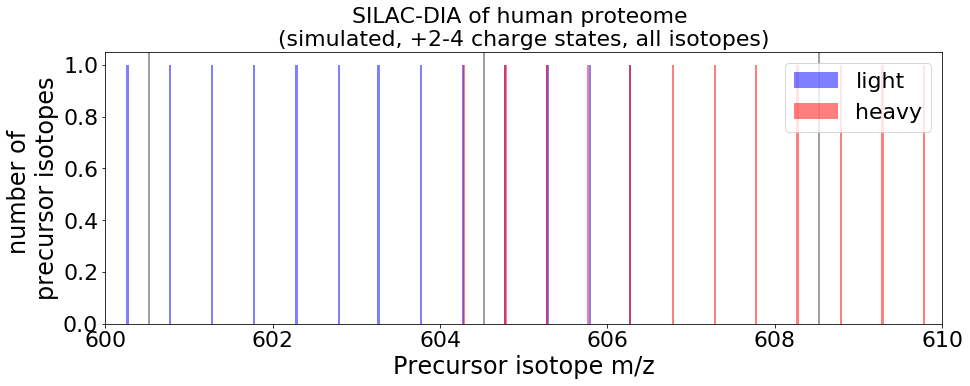

In [7]:
from molmass import Formula

# calculate m/z from relative mass column for (M+2H)2+
def calculate_mz(row, z):
    mz = (row['Relative Mass'] + z*(mass.calculate_mass(formula='H')))/z
    return mz

def calculate_heavy_mass(row, z):
    mz_heavy = 0
    
    if row['Peptide Seq'][-1] == 'R':
        mz_heavy = row['mz_light']+(10.008269/z)
    elif row['Peptide Seq'][-1] == 'K':
        mz_heavy = row['mz_light']+(8.014199/z)
        
    return mz_heavy

def calculate_isotopic_envelope(peptide):
    
    # calculate [relative mass, frx]
    temp_iso = Formula(peptide)

    # turn dictionary into a dataframe
    temp_iso = pd.DataFrame.from_dict(temp_iso.spectrum(), 
                                      orient='index', columns=['Relative Mass', 'Fraction'])
    temp_iso['Peptide Seq'] = peptide
    temp_iso_3 = temp_iso

    # calculate m/z from relative mass column for (M+2H)2+
    temp_iso['charge'] = 2.0
    temp_iso['mz_light'] = temp_iso.apply(lambda x: calculate_mz(x, 2), axis=1)
    temp_iso['mz_heavy'] = temp_iso.apply(lambda x: calculate_heavy_mass(x, 2), axis=1)
    temp_iso = temp_iso.reset_index(drop=True)
    
    # calculate m/z from relative mass column for (M+3H)3+
    temp_iso_3['charge'] = 3.0
    temp_iso_3['mz_light'] = temp_iso_3.apply(lambda x: calculate_mz(x, 3), axis=1)
    temp_iso_3['mz_heavy'] = temp_iso_3.apply(lambda x: calculate_heavy_mass(x, 3), axis=1)
    
    temp_iso = temp_iso.append(temp_iso_3)
    
    return temp_iso

pep = ['GQPGEMGDPGPR']
isotopic_env_df = pd.DataFrame()
for peptide in pep:
    isotopic_env_df = isotopic_env_df.append(calculate_isotopic_envelope(peptide))

    
plt.subplots(figsize=(15, 5), facecolor='white')
temp1 = isotopic_env_df[isotopic_env_df['mz_light'].between(599, 611, inclusive=False)]
temp2 = isotopic_env_df[isotopic_env_df['mz_heavy'].between(599, 611, inclusive=False)]
plt.hist(temp1['mz_light'], bins=250, alpha=0.5, color='blue', label='light')
plt.hist(temp2['mz_heavy'], bins=250, alpha=0.5, color='red', label='heavy')
plt.axvline(x=600.5228,color='gray')
plt.axvline(x=608.5265,color='gray')
plt.axvline(x=604.52466,color='gray')
plt.xlim(600, 610)
plt.legend(loc='upper right')
plt.title('SILAC-DIA of human proteome \n(simulated, +2-4 charge states, all isotopes)')
plt.ylabel('number of \nprecursor isotopes')
plt.xlabel('Precursor isotope m/z')

In [8]:
temp1 = silac_df[silac_df['mz_light'].between(599, 611, inclusive=False)]
temp2 = silac_df[silac_df['mz_heavy'].between(599, 611, inclusive=False)]
silac_subset_df = temp1.append(temp2)
silac_subset_df.drop_duplicates(inplace=True)

isotopic_env_df = pd.DataFrame()
for peptide in tqdm(silac_subset_df['light'].drop_duplicates()):
    isotopic_env_df = isotopic_env_df.append(calculate_isotopic_envelope(peptide))
    
isotopic_env_df.to_csv("../data/simulated/silac_insilico_nomissedcleavages_charge2and3_isotopic.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████| 10021/10021 [03:17<00:00, 50.82it/s]


Text(0.5, 0, 'Precursor isotope m/z')

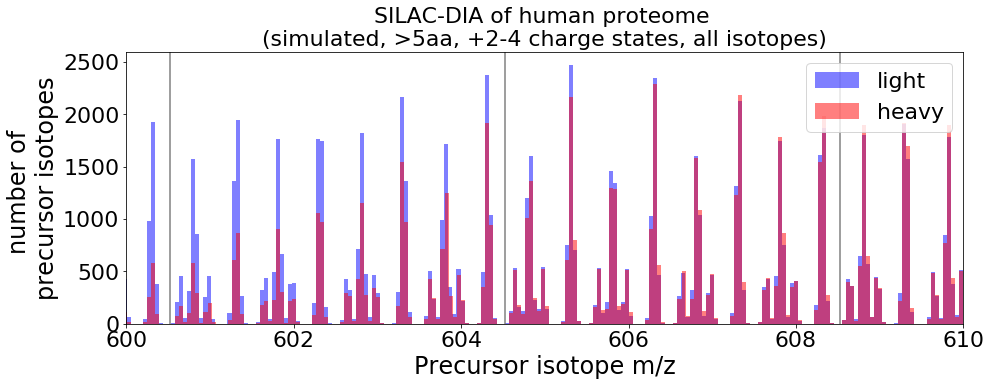

In [9]:
plt.subplots(figsize=(15, 5), facecolor='white')
temp1 = isotopic_env_df[isotopic_env_df['mz_light'].between(599, 611, inclusive=False)]
temp2 = isotopic_env_df[isotopic_env_df['mz_heavy'].between(599, 611, inclusive=False)]
plt.hist(temp1['mz_light'], bins=250, alpha=0.5, color='blue', label='light')
plt.hist(temp2['mz_heavy'], bins=250, alpha=0.5, color='red', label='heavy')
plt.axvline(x=600.5228,color='gray')
plt.axvline(x=608.5265,color='gray')
plt.axvline(x=604.52466,color='gray')
plt.xlim(600, 610)
plt.legend(loc='upper right')
plt.title('SILAC-DIA of human proteome \n(simulated, >5aa, +2-4 charge states, all isotopes)')
plt.ylabel('number of \nprecursor isotopes')
plt.xlabel('Precursor isotope m/z')

WWDNINVQK


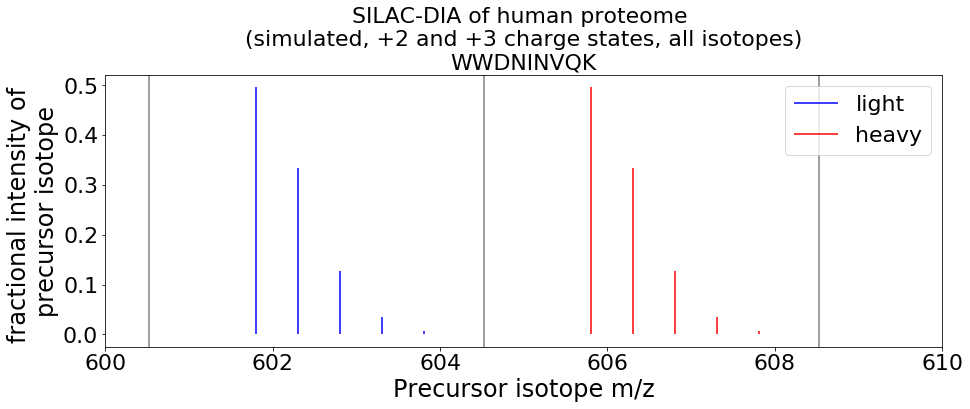

In [22]:
def plot_isoenv(peptide):
    temp1b = temp1[temp1['Peptide Seq'] == peptide]
    temp2b = temp2[temp2['Peptide Seq'] == peptide]

    SMALL_SIZE = 22
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 26

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.subplots(figsize=(15, 5), facecolor='white')
    plt.vlines(x=temp1b['mz_light'], ymin=0, ymax=temp1b['Fraction'], color='blue', label='light')
    plt.vlines(x=temp2b['mz_heavy'], ymin=0, ymax=temp2b['Fraction'], color='red', label='heavy')
    plt.axvline(x=600.5228,color='gray')
    plt.axvline(x=608.5265,color='gray')
    plt.axvline(x=604.52466,color='gray')
    plt.xlim(600, 610)
    plt.legend(loc='upper right')
    title = 'SILAC-DIA of human proteome \n(simulated, +2 and +3 charge states, all isotopes)\n'+peptide
    plt.title(title)
    plt.ylabel('fractional intensity of \nprecursor isotope')
    plt.xlabel('Precursor isotope m/z')

    plt.savefig('../results/simulated_precursor_dist_isotopicdist_'+peptide+'.svg', 
                transparent=True, bbox_inches='tight', pad_inches=0.5)

# plot a random peptide
import random
peptides = list(set().union(temp1['Peptide Seq'],temp2['Peptide Seq']))
peptide = random.choice(peptides); print(peptide)
plot_isoenv(peptide)



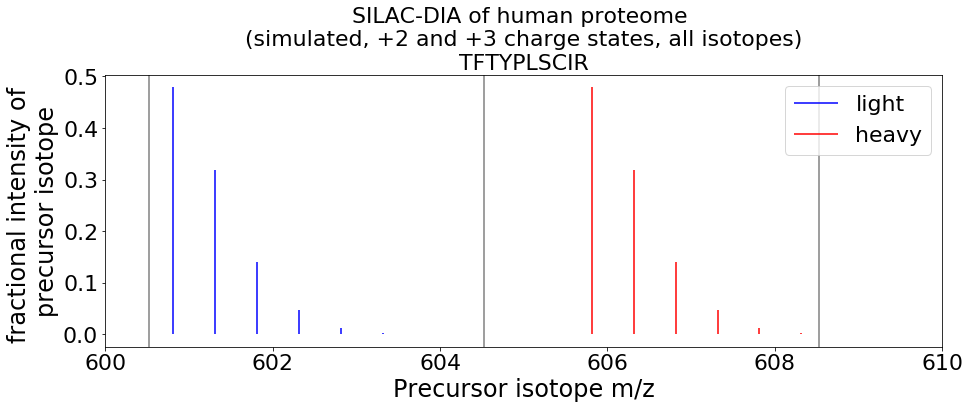

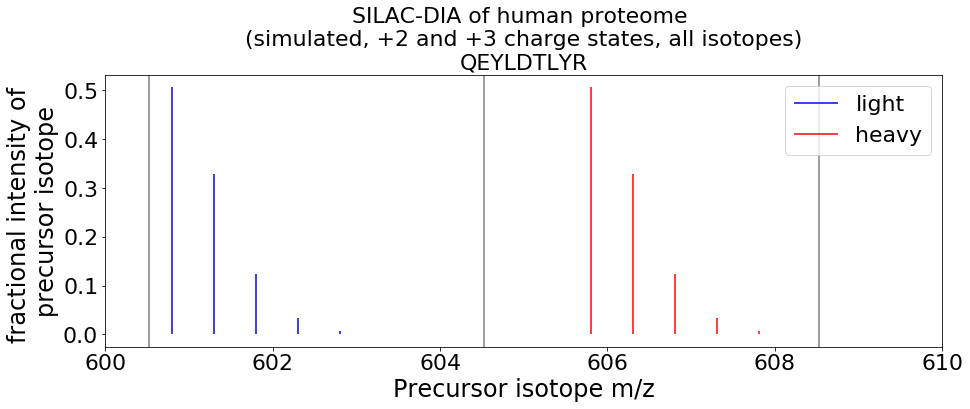

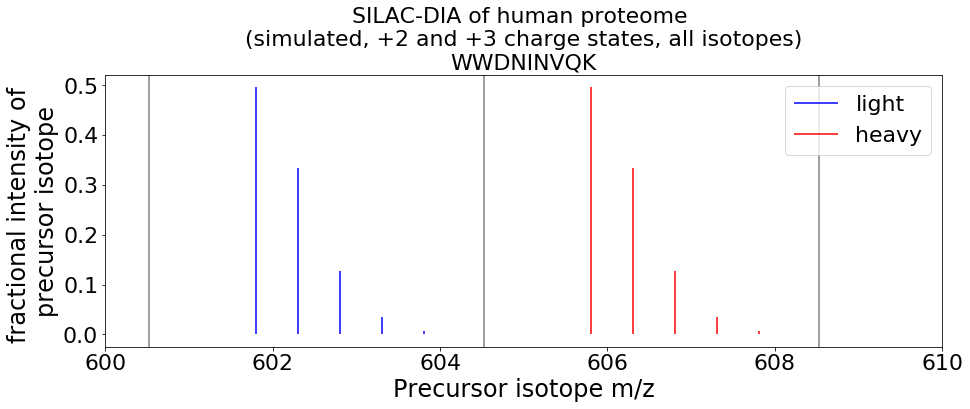

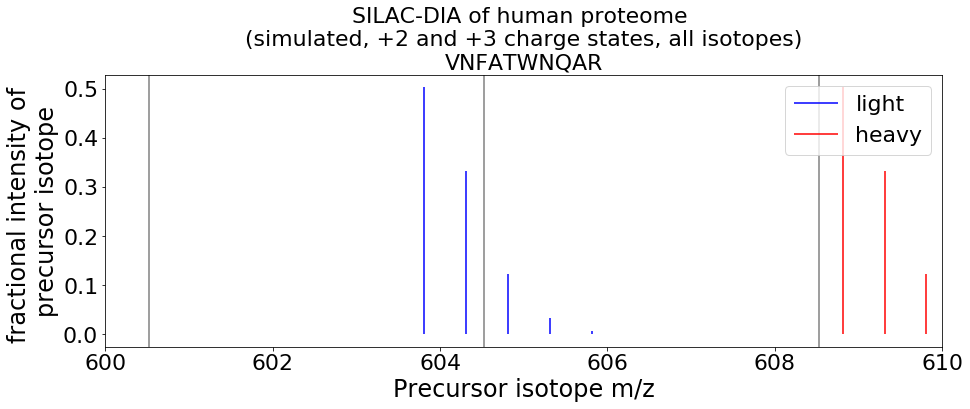

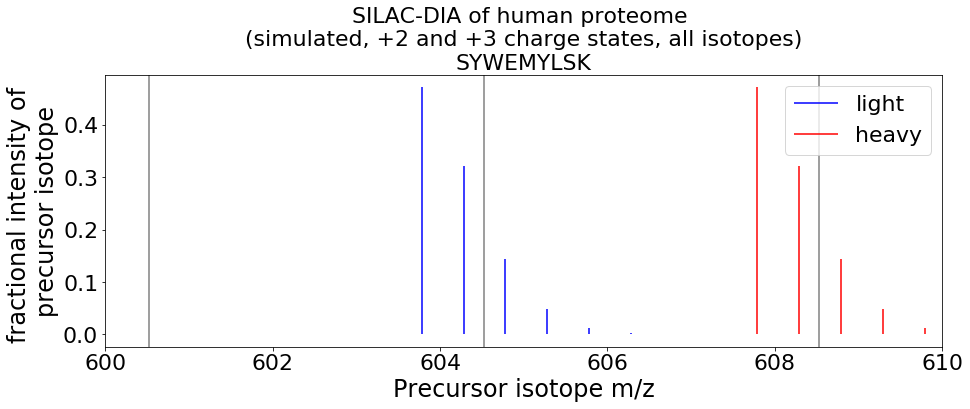

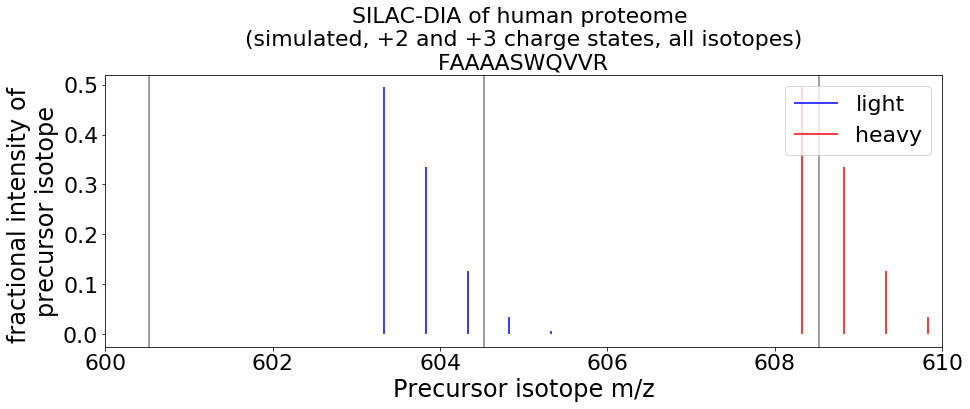

In [24]:
# plot specific peptides
peptides = ['TFTYPLSCIR', 'QEYLDTLYR', 'WWDNINVQK',
           'VNFATWNQAR', 'SYWEMYLSK', 'FAAAASWQVVR']

for peptide in peptides:
    plot_isoenv(peptide)
    plt.savefig('../results/simulated_precursor_dist_isotopicdist_'+peptide+'.svg', 
                transparent=True, bbox_inches='tight', pad_inches=0.5)